# Hackaton Ciencias de Redes
## Grupo 5
- #### Patricio Ramirez
- #### Carlos Bustamante
- #### Victor Ortiz
- #### Pablo Elgueta

## Tarea

#### Objetivo General: 
    Determinar patrones potenciales de corrupción en compras públicas en Chile. Para esto, se disponibilizarán los datos de todos las licitaciones públicas en Chile entre 2014 y 2021. Deben elegir un periodo a estudiar y que los datos son pesados.
    
#### 1) Análisis Exploratorio: 
    Puede incluir histogramas, relaciones bivariadas, correlaciones (coeficientes y figuras), etc.
#### 2) Inferencia red: 
    Red bipartita, proyección unimodal de la red bipartita, modelos nulos para filtrar (phi correlation, randomización preservando grado, etc)
#### 3) Descripción de la red: 
    Distribución de grados (antes y despues de filtrar), gráfico grado de nodo vs coeficiente de clustering, diámetro de la red, número de nodos, número de enlaces, densidad. Detección de comunidades, etc.
#### 4) Identifiación de patrones de corrupción en la red: 
    El trabajo es abierto en términos de identificación de patrones, sin embargo, pueden usar lo siguiente:
- 1) Índice de diversidad de simpson por comunidad (ver referencia 1)
- 2) índice de entropía del buyer (oferente) (ver referncia 2)
- 3) Licitaciones con solo 1 bider (ofertante) (ver referencia 1 y 2) [esto es uno de los indicadores de potencial
riesgo de corrupción, ver CRI referencia 2 y 3]
- 4) Coefcieinte de clustering competitivo (si trabajan con la red bipartita sin proyectar) (ver referencia 2)
- 5) Datos externos si encuentan y alcanzan son bienvenidos.
- 6) Otros.

### Importación de Librerías

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from networkx.algorithms import bipartite

# Desarrollo de Proyecto

## Objetivos e Hipotesis

- ¿Existe una relación que se repita de forma sostenida entre Organismos Públicos y Privados, con los Proveedores para el periodo a analizar?(2020).
- Desarrollo de una red bipartita para nuestro análisis.
- Trabajar en base al componente gigante de la red.
- Identificar patrones de corrupción en la red.

### 1) Análisis Exploratorio: 

In [2]:
df = pd.read_csv('lic2020_hackaton.csv', sep=',', encoding='latin_1')

In [3]:
df.head(3)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada


In [4]:
print('Cantidad de Nombres de Organismo:')
print(len(df['NombreOrganismo'].unique()))
print('\nCantidad de Codigos de Organismo:')
print(len(df['CodigoOrganismo'].unique()))

Cantidad de Nombres de Organismo:
859

Cantidad de Codigos de Organismo:
871


- ###### Del análisis de datos, fué posible identificar que existen 2 grupos de nodos mediante los cuales es posible generar una Red Bipartita. El primer Grupo contempla las primeras columnas de datos que se encuentras asociadas a los Organismos estatales que generan las Licitaciones. Por otro lado, el conjunto de columnas de la izquierda corresponden a las Empresas participantes de las licitaciones.

- ###### Dentro del análisis exploratiorio de los datos, fue posible identificar que las cantidades de CodigosOrganismos no coincidía con la de NombreOrganismos, lo cual eventualmente significaría que existen Organismos con más de un código asociado, lo que nos inclina por trabajar con los Nombres.

- ###### Otra observación que pudimos identificar, es que algunas de las empresas que participan como oferentes, se en cuentran también dentro del listado de Organismos, estas corresponden a aquellas empresas estatales como universidades, las cuales poseen áreas de proyectos o investigación para el autofinanciamiento.

### 2) Inferencia red:

#### Lista de Nodos de Organismos

In [5]:
lista_organismos = df['NombreOrganismo'].unique()
lista_organismos[0:5]
len(lista_organismos)

859

#### Lista de Nodos de Empresas

In [6]:
lista_empresas = df['NombreProveedor'].unique()
lista_empresas[0:5]
len(lista_empresas)

38663

#### Eliminar Nodos Preentes en Ambos Grupos de Nodos

In [7]:
del_empresas = []
for organismo in lista_organismos:
    for empresa in lista_empresas:
        if organismo == empresa:
            del_empresas.append(organismo)
del_empresas

['UNIVERSIDAD DE MAGALLANES',
 'UNIVERSIDAD DEL BIO BIO',
 'UNIVERSIDAD DE ATACAMA',
 'UNIVERSIDAD DE TALCA',
 'UNIVERSIDAD DE LA FRONTERA',
 'INSTITUTO FORESTAL',
 'INSTITUTO DE FOMENTO PESQUERO']

In [8]:
for universidad in del_empresas:
    df = df[df['NombreProveedor'] != universidad]

In [9]:
lista_empresas = df['NombreProveedor'].unique()
len(lista_empresas)

38656

#### Definición de Enlaces Empresas/Organismos

In [10]:
#df = df[df['ComunaUnidad'] == 'Santiago']  #'''Este código solo se usa para hacer pruebas por motivos de procesamiento'''
G = nx.Graph()
G.add_nodes_from(lista_empresas, bipartite=0)
G.add_nodes_from(lista_organismos,bipartite=1)

In [11]:
df.head(3)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada


In [12]:
pivot = pd.pivot_table(df, index=['NombreOrganismo','NombreProveedor'],values=['Oferta seleccionada'],aggfunc='count')
pivot = pivot.reset_index()
pivot.head()

,NombreOrganismo,NombreProveedor,Oferta seleccionada
0,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,ARTL CHILE AUDITORES SPA,1
1,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,AdjudicaChile Consultora en Licitaciones Públicas,1
2,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Aiguasol,2
3,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Amelia Virginia,1
4,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Astral S.A.,1


In [13]:
lista_tuplas_pesos = []

for i in pivot.to_numpy():
    lista_tuplas_pesos.append((i[0], i[1], i[2]))

In [41]:
lista_tuplas_pesos[:4]

[('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'ARTL CHILE AUDITORES SPA',
  1),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'AdjudicaChile Consultora en Licitaciones Públicas',
  1),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'Aiguasol',
  2),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'Amelia Virginia',
  1)]

In [15]:
len(lista_tuplas_pesos)

213920

#### Construcción del Grafo

In [16]:
G = nx.Graph()

In [17]:
G.add_nodes_from(lista_empresas, bipartite=0)
G.add_nodes_from(lista_organismos,bipartite=1)

In [18]:
G.add_weighted_edges_from(lista_tuplas_pesos)

In [19]:
bipartite.is_bipartite(G)

True

In [20]:
nx.density(G)

0.00027401125624970494

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

In [22]:
from community import community_louvain

partition = community_louvain.best_partition(G)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))

Se detectan 14 comunidades


In [23]:
d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]


In [24]:
for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Tamaño Comunidad 0: 3033
Tamaño Comunidad 1: 2067
Tamaño Comunidad 2: 8800
Tamaño Comunidad 3: 54
Tamaño Comunidad 4: 3266
Tamaño Comunidad 5: 4
Tamaño Comunidad 6: 5627
Tamaño Comunidad 7: 3227
Tamaño Comunidad 8: 5202
Tamaño Comunidad 9: 7431
Tamaño Comunidad 10: 7
Tamaño Comunidad 11: 560
Tamaño Comunidad 12: 236
Tamaño Comunidad 13: 1


In [25]:
pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)

In [27]:
len(pos)

39515

In [28]:
len(lista_organismos)+len(lista_empresas)

39515

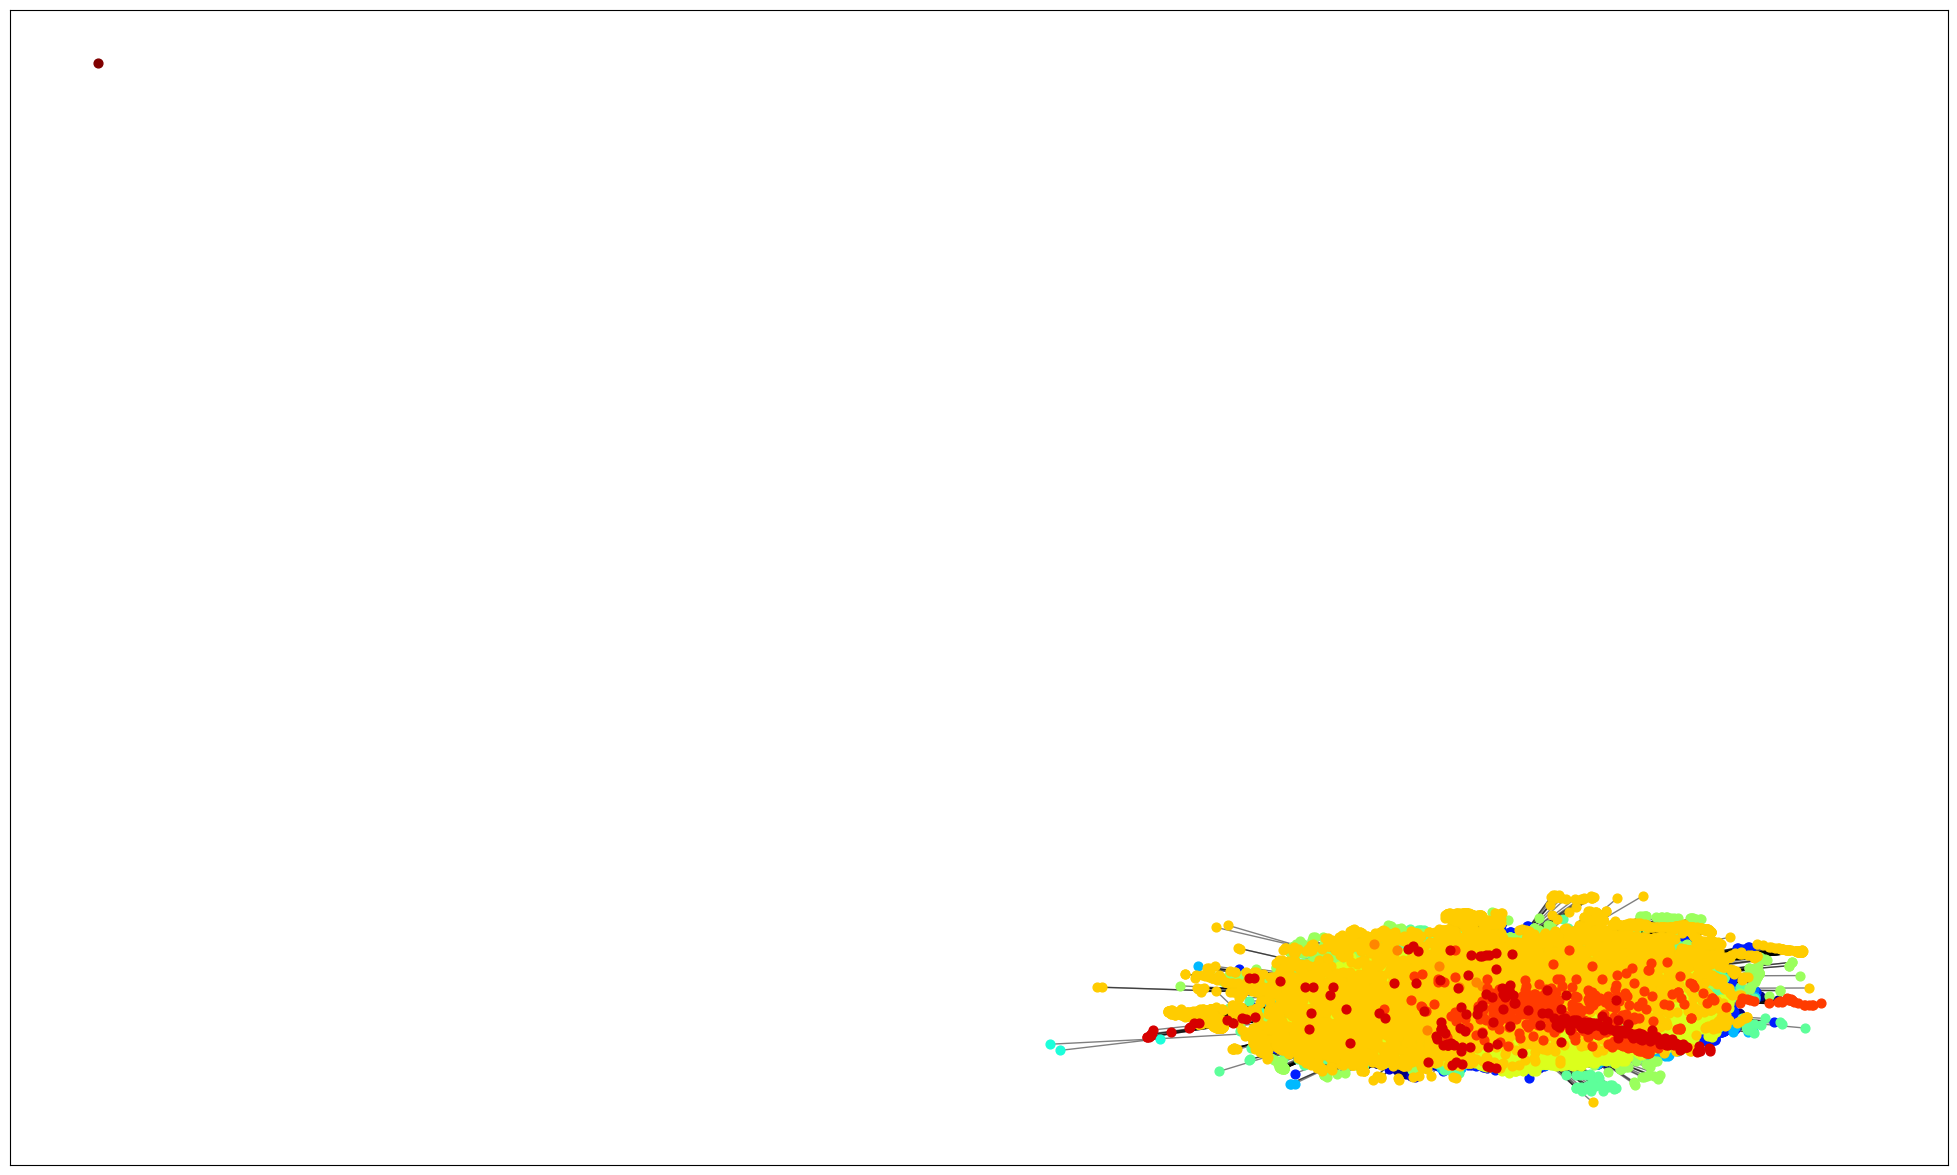

In [40]:
plt.figure(figsize=(25, 15))

colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet

count = 0
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 40, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores

nx.draw_networkx_edges(G, pos, alpha=0.5)#plotea enlaces
plt.show()
